In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


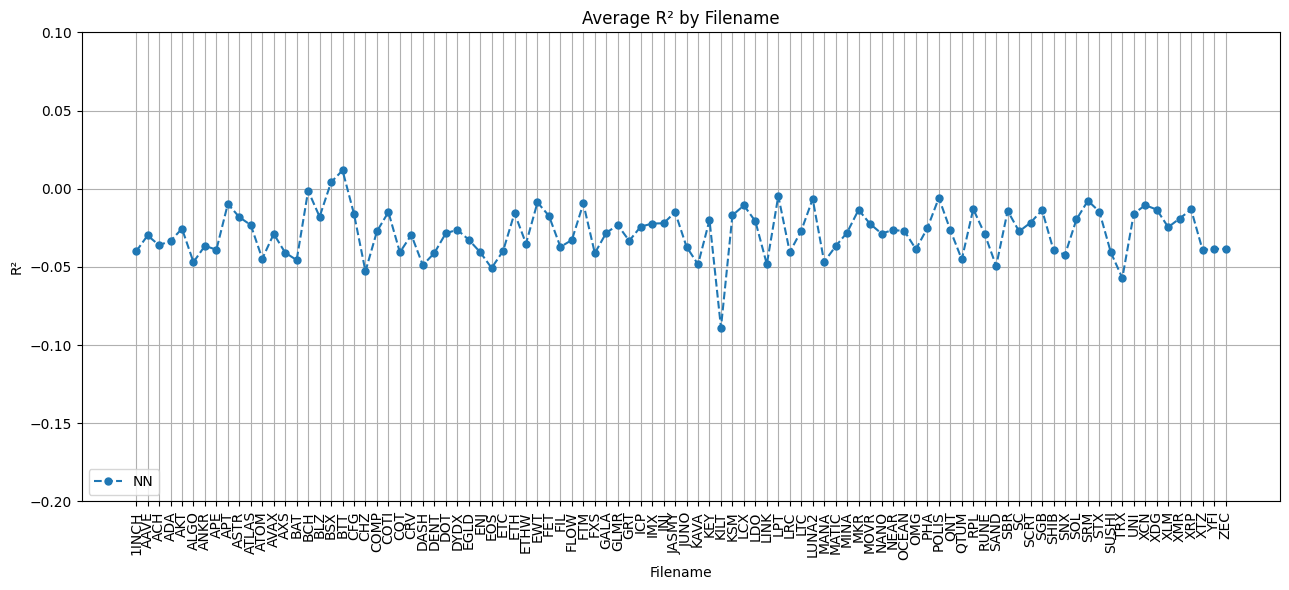

In [ ]:
files = {
    'NN':  '../modeling/MLPRegressor_predictions_one_model.parquet',
    # 'RF':  '../modeling/RF_predictions_one_model.parquet',
    # 'XGB': '../modeling/XGB_predictions_one_model.parquet',
    # 'RF_ind': '../modeling/RF_predictions_ind_models.parquet',
}

# gather all coin names across files
all_coins = set()
for path in files.values():
    tmp = pd.read_parquet(path)
    coins = tmp['filename'].str.split('_').str[0].str[:-3]
    all_coins |= set(coins.unique())
coin_names = sorted(all_coins)
x = np.arange(len(coin_names))

fig, ax = plt.subplots(figsize=(13, 6))
all_r2_scores = {}
for label, path in files.items():
    res = pd.read_parquet(path)
    res['coin_name'] = res['filename'].str.split('_').str[0].str[:-3]
    r2_scores = (
        res.groupby('coin_name')
           .apply(lambda x: r2_score(x['next_return'], x['pred']))
           .reindex(coin_names)   # align to full coin list
    )
    y = r2_scores.values
    ax.plot(x, y, 'o--', markersize=5, label=label)
    all_r2_scores[label] = r2_scores

ax.set_xticks(x)
ax.set_xticklabels(coin_names, rotation=90)
ax.set_xlabel("Filename")
ax.set_ylabel("R²")
ax.set_title("Average R² by Filename")
ax.set_ylim(-0.1, 0.1)
ax.grid(True)
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

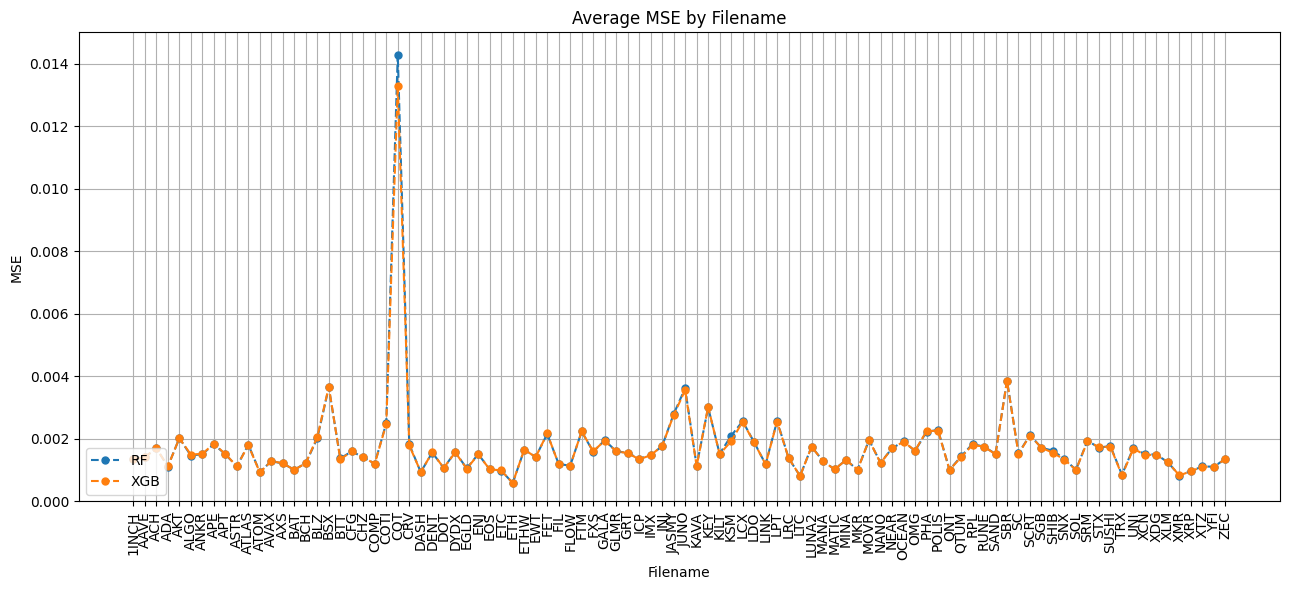

In [29]:
files = {
    # 'NN':  '../modeling/MLPRegressor_predictions_one_model.parquet',
    'RF':  '../modeling/RF_predictions_one_model.parquet',
    'XGB': '../modeling/XGB_predictions_one_model.parquet',
    # 'RF_ind': '../modeling/RF_predictions_ind_models.parquet',
}

# gather all coin names across files
all_coins = set()
for path in files.values():
    tmp = pd.read_parquet(path)
    coins = tmp['filename'].str.split('_').str[0].str[:-3]
    all_coins |= set(coins.unique())
coin_names = sorted(all_coins)
x = np.arange(len(coin_names))

fig, ax = plt.subplots(figsize=(13, 6))
all_r2_scores = {}
for label, path in files.items():
    res = pd.read_parquet(path)
    res['coin_name'] = res['filename'].str.split('_').str[0].str[:-3]
    r2_scores = (
        res.groupby('coin_name')
           .apply(lambda x: mean_squared_error(x['next_return'], x['pred']))
           .reindex(coin_names)   # align to full coin list
    )
    y = r2_scores.values
    ax.plot(x, y, 'o--', markersize=5, label=label)
    all_r2_scores[label] = r2_scores

ax.set_xticks(x)
ax.set_xticklabels(coin_names, rotation=90)
ax.set_xlabel("Filename")
ax.set_ylabel("MSE")
ax.set_title("Average MSE by Filename")
ax.set_ylim(0, 0.015)
ax.grid(True)
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

In [27]:
combined = pd.DataFrame(all_r2_scores, index=coin_names)

In [28]:
len(combined.loc[combined.XGB > combined.RF]) / len(combined)

0.4270833333333333

In [64]:
def plot_r2_metrics(all_preds):
    r2_metrics = {}
    count_metrics = {}

    for thr in np.arange(0, 1, 0.005):
        subset = all_preds.loc[np.abs(all_preds['pred']) >= thr]
        n = len(subset)
        if n == 0:
            break

        count_metrics[thr] = n

        r2_metrics[thr] = r2_score(subset['next_return'], subset['pred'])
        if r2_metrics[thr] < -3:
            r2_metrics[thr] = -3
            break

    r2_metrics = pd.Series(r2_metrics).sort_index()
    count_metrics = pd.Series(count_metrics).sort_index()
    # print(f"R² metrics: {r2_metrics}")
    # print(f"Count metrics: {count_metrics}")
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(
        r2_metrics.index,
        r2_metrics.values,
        marker='o',
        color='purple',
        label='R²'
    )
    ax1.axhline(0, color='red', linestyle='--', alpha=0.3)
    ax1.set_xlabel('Threshold on |pred|')
    ax1.set_ylabel('R²', color='purple')
    ax1.tick_params(axis='y', labelcolor='purple')

    x_vals = r2_metrics.index.values
    y_vals = r2_metrics.values
    y_min, y_max = y_vals.min(), y_vals.max()
    offset = (y_max - y_min) * 0.04
    for i in range(len(y_vals)):
        y_curr = y_vals[i]
        y_next = y_vals[i + 1] if i < len(y_vals) - 1 else y_vals[i - 1]
        y_prev = y_vals[i - 1] if i > 0 else y_vals[i + 1]

        if y_next > y_curr and y_prev > y_curr:
            y_pos = y_curr - offset
            va = 'bottom'
        elif y_next <= y_curr and y_prev <= y_curr:
            y_pos = y_curr + offset
            va = 'top'
        else:
            y_pos = y_curr - offset
            va = 'bottom'

        ax1.text(
            x_vals[i],
            y_pos,
            f"{y_curr:.2f}",
            ha='center',
            va=va,
            fontsize=8,
            color='purple'
        )


    ax2 = ax1.twinx()
    bars = ax2.bar(
        count_metrics.index,
        count_metrics.values,
        width=0.005,
        alpha=0.3,
        color='blue',
        label='Count'
    )
    ax2.set_ylabel('Number of samples (log)', color='blue')
    ax2.set_yscale('log')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax2.set_ylim(1, count_metrics.max() * 100)

    for x, y in zip(count_metrics.index, count_metrics.values):
        ax2.text(
            x,
            y * 1.05,
            str(int(y)),
            ha='center',
            va='bottom',
            fontsize=6,
            color='blue'
        )
    ax1.set_title('R² and Count Metrics by Threshold on |pred|')
    fig.tight_layout()
    plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

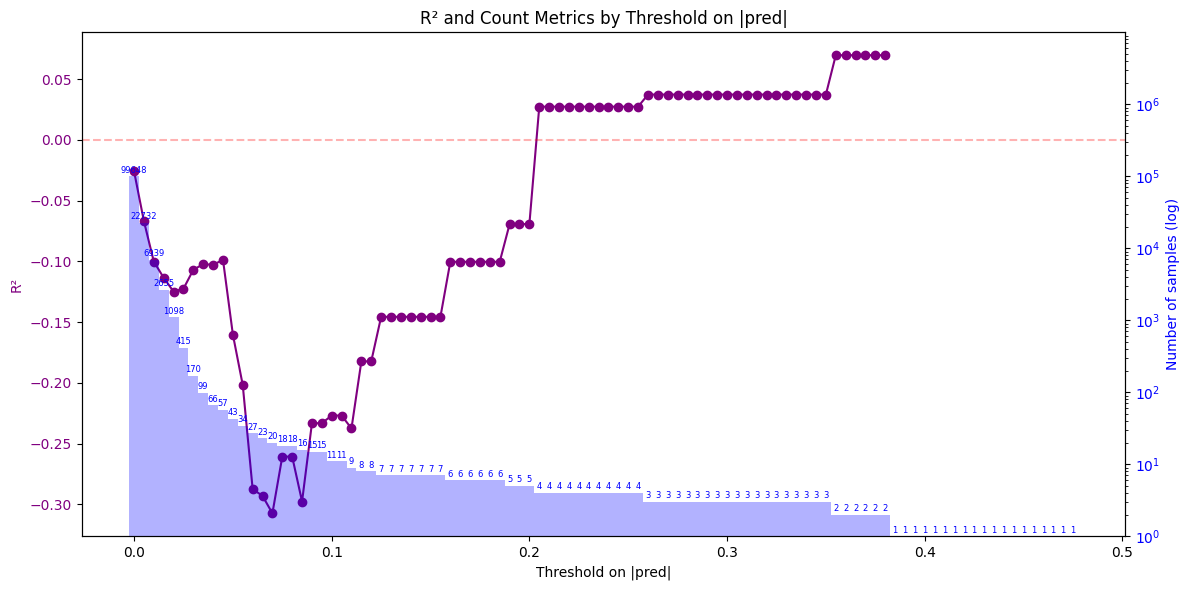

In [69]:
plot_r2_metrics(pd.read_parquet(files['NN']))

In [56]:
tmp = pd.read_parquet(files['XGB'])
tmp['sign_agree'] = np.sign(tmp['next_return']) == np.sign(tmp['pred'])

In [57]:
tmp.loc[abs(tmp['pred']) >= 0.01].sign_agree.value_counts(normalize=True)

sign_agree
True     0.636364
False    0.363636
Name: proportion, dtype: float64

In [60]:
tmp.loc[abs(tmp['pred']) >= 0.01][['pred', 'next_return']].corr()

,pred,next_return
pred,1.000000,0.258289
next_return,0.258289,1.000000


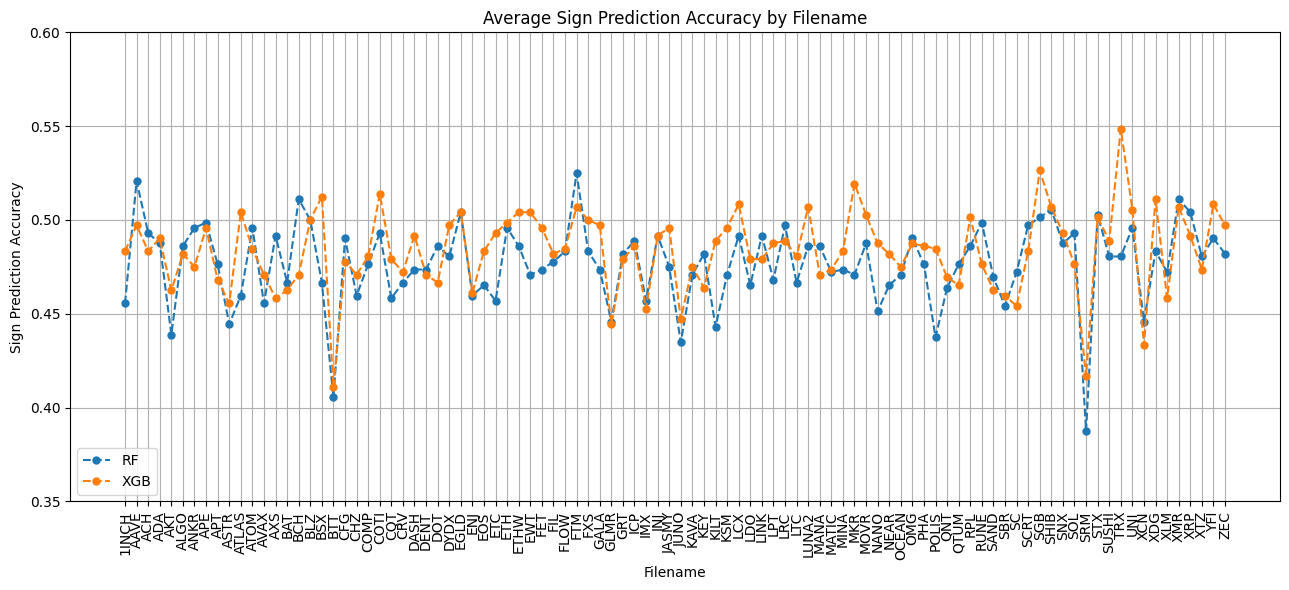

In [32]:
files = {
    # 'NN':  '../modeling/MLPRegressor_predictions_one_model.parquet',
    'RF':  '../modeling/RF_predictions_one_model.parquet',
    'XGB': '../modeling/XGB_predictions_one_model.parquet',
}

# gather all coin names across files
all_coins = set()
for path in files.values():
    tmp = pd.read_parquet(path)
    coins = tmp['filename'].str.split('_').str[0].str[:-3]
    all_coins |= set(coins.unique())
coin_names = sorted(all_coins)
x = np.arange(len(coin_names))

fig, ax = plt.subplots(figsize=(13, 6))

for label, path in files.items():
    res = pd.read_parquet(path)
    res['coin_name'] = res['filename'].str.split('_').str[0].str[:-3]
    r2_scores = (
        res.groupby('coin_name')
           .apply(lambda x: np.mean(np.sign(x['next_return']) == np.sign(x['pred'])))
           .reindex(coin_names)   # align to full coin list
    )
    y = r2_scores.values
    ax.plot(x, y, 'o--', markersize=5, label=label)

ax.set_xticks(x)
ax.set_xticklabels(coin_names, rotation=90)
ax.set_xlabel("Filename")
ax.set_ylabel("Sign Prediction Accuracy")
ax.set_title("Average Sign Prediction Accuracy by Filename")
ax.set_ylim(0.35, 0.6)
ax.grid(True)
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

In [72]:
xgb_feat_imp = pd.read_csv('../modeling/XGB_feature_importances.csv')
xgb_feat_imp.columns = ['feature', 'importance']
rf_feat_imp = pd.read_csv('../modeling/RF_feature_importances.csv')
rf_feat_imp.columns = ['feature', 'importance']

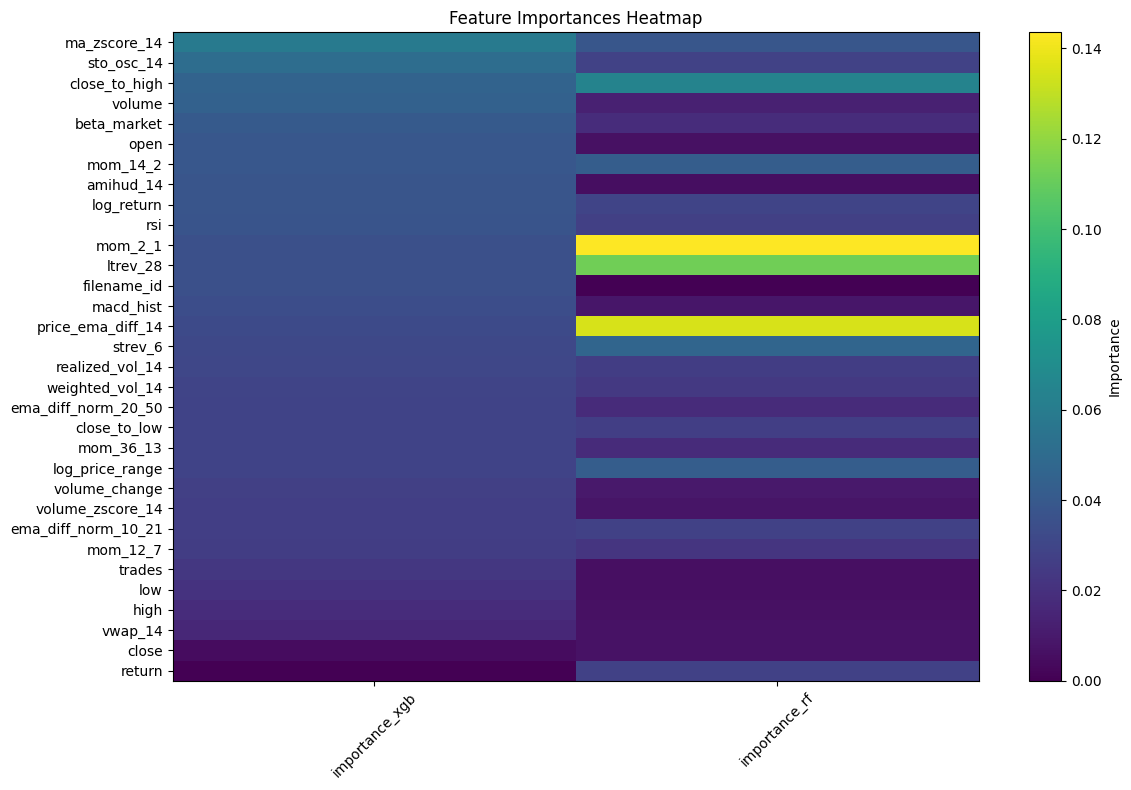

In [87]:
# Heatmap of feature importances
importances = pd.merge(xgb_feat_imp, rf_feat_imp, on='feature', suffixes=('_xgb', '_rf'), how='outer')
importances.sort_values(by='importance_xgb', ascending=False, inplace=True)
importances = importances.set_index('feature')
importances = importances.fillna(0)  # Fill NaN values with 0 for better visualization
plt.figure(figsize=(12, 8))
plt.imshow(importances, aspect='auto', cmap='viridis')
plt.colorbar(label='Importance')
plt.xticks(ticks=np.arange(len(importances.columns)), labels=importances.columns, rotation=45)
plt.yticks(ticks=np.arange(len(importances.index)), labels=importances.index)
plt.title('Feature Importances Heatmap')
plt.tight_layout()
plt.show()

In [88]:
importances.describe()

,importance_xgb,importance_rf
count,32.000000,32.000000
mean,0.031250,0.031250
std,0.011787,0.035695
min,0.000000,0.000000
25%,0.026776,0.007588
50%,0.030861,0.023022
75%,0.038072,0.031570
max,0.059041,0.143575


In [89]:
files = {
    'NN':  '../modeling/MLPRegressor_predictions_one_model.parquet',
    'RF':  '../modeling/RF_predictions_one_model.parquet',
    'XGB': '../modeling/XGB_predictions_one_model.parquet',
    'RF_ind': '../modeling/RF_predictions_ind_models.parquet',
}

In [96]:
for file in files.keys():
    res = pd.read_parquet(files[file])
    mse = mean_squared_error(res['next_return'], res['pred'])
    r2 = r2_score(res['next_return'], res['pred'])
    sign_acc = np.mean(np.sign(res['next_return']) == np.sign(res['pred']))
    print(f"{file}: MSE={mse:.6f}, R²={r2:.4f}, Sign Accuracy={sign_acc:.4f}")

NN: MSE=0.001460, R²=-0.0257, Sign Accuracy=0.4929
RF: MSE=0.001733, R²=-0.0046, Sign Accuracy=0.4768
XGB: MSE=0.001715, R²=0.0054, Sign Accuracy=0.4836
RF_ind: MSE=0.001792, R²=-0.1391, Sign Accuracy=0.4998


In [95]:
res.loc[np.sign(res.pred) == np.sign(res.next_return)].shape[0] / res.shape[0]

0.4997823383084577

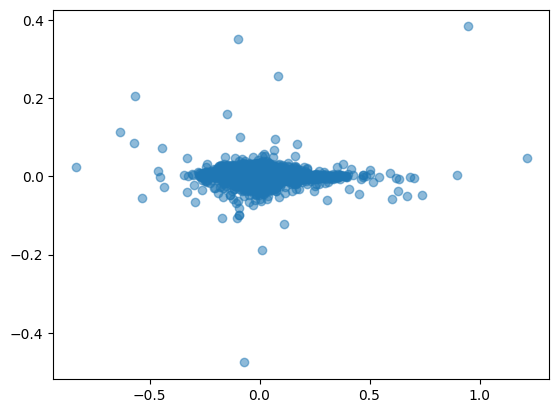

In [99]:
nn = pd.read_parquet(files['NN'])
plt.scatter(nn['next_return'], nn['pred'], alpha=0.5)